In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance


In [2]:
def norm(arr):
    arr = arr.astype(np.float)
    arr -= arr.min()
    arr /= arr.max()
    return arr

In [3]:
# load MNIST data set
mnist = load_digits()
X, Y = mnist.data, mnist.target

# normalize inputs to 0-1 range
X = norm(X)

# split into train, validation, and test data sets
X_train, X_test, Y_train, Y_test = train_test_split(X,       Y,       test_size=200, random_state=0)
labels = np.random.binomial(n=1, p=0.5, size=[1000]).reshape(1000,1)

In [3]:
indices = ["0", "1", "10", "11", "12", "13"]
data_S = []
for index in indices:
    data = np.load(f"../data/data{index}.npy")
    data_S.append(data)

In [4]:
for data in data_S:
    print(data.shape)

(291, 275, 442)
(282, 274, 442)
(259, 275, 442)
(271, 278, 442)
(284, 278, 442)
(286, 278, 442)


In [5]:
target_width = 259
target_height = 259
cropped_data = []
for data in data_S:
    
    current_height, current_width, _ = data.shape

    # Calculate the starting points for cropping
    start_x = (current_width - target_width) // 2
    start_y = (current_height - target_height) // 2

    # Crop the image
    cropped_dat = data[start_y:start_y+target_height, start_x:start_x+target_width, :]


    cropped_data.append(cropped_dat)

In [6]:
np.array(cropped_data).shape

(6, 259, 259, 442)

In [7]:
target_width = 259
target_height = 259
train = []
for data in cropped_data:
    for i in range(259):
        for j in range(259):
            data_point = data[i,j,:]
            train.append(data_point)

train = np.array(train)

In [8]:
train.shape

(402486, 442)

In [9]:
d2_train_dataset = norm(train)
train , test =  train_test_split(d2_train_dataset, test_size=int(d2_train_dataset.shape[0] * 0.1), random_state=0)

In [10]:
train.shape

(362238, 442)

In [11]:
test.shape

(40248, 442)

In [12]:
# --------------------------------------------------------------------------------
# set hyperparameters

learning_rate = 0.001
total_units   =  300 
total_epochs  =   50 
batch_size    =  32 

# --------------------------------------------------------------------------------
# construct models

# RBM
rbm1 = BernoulliRBM(n_components=total_units, learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs, verbose=2)
rbm2 = BernoulliRBM(n_components=int(total_units/2), learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs, verbose=2)
rbm3 = BernoulliRBM(n_components=int(total_units/4), learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs, verbose=2)
rbm4 = BernoulliRBM(n_components=int(total_units/6), learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs, verbose=1)


models = []                       
model = Pipeline(steps=[('rbm1', clone(rbm1)), ('rbm2', clone(rbm2)),('rbm3', clone(rbm3))])  # RBM stack / DBN
# --------------------------------------------------------------------------------
# train and evaluate models

model.fit(train)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -121.12, time = 59.29s


KeyboardInterrupt: 

In [5]:
def sigmoid_activation(x):
    """
    Numerically stable sigmoid function with clipping.
    
    :param x: Input array.
    :return: Sigmoid of x.
    """
    # Clip x to avoid overflow in exp
    clipped_x = np.clip(x, -500, 500)

    return np.where(clipped_x >= 0, 
                    1 / (1 + np.exp(-clipped_x)), 
                    np.exp(clipped_x) / (1 + np.exp(clipped_x)))


def reconstruct_visible(rbm, hidden):
    """
    Reconstruct the visible units from the hidden units in an RBM.

    :param rbm: Trained instance of BernoulliRBM.
    :param hidden: Array of hidden units.
    :return: Reconstructed visible units.
    """
    # Compute the activation of the visible units
    v_activation = np.dot(hidden, rbm.components_) + rbm.intercept_visible_

    # Compute the probability of the visible units given the hidden units
    v_prob = sigmoid_activation(v_activation)

    # Sample from these probabilities to get the binary visible units
    # For BernoulliRBM, this step can be binary sampling or directly using probabilities
    v_reconstructed = np.random.binomial(1, v_prob)

    return v_reconstructed

In [10]:
hidden_features = model.transform(test)
# Initialize the reconstructed data with the hidden features
reconstructed_data = hidden_features

# Reconstruct the data from the top RBM to the bottom
for rbm in reversed(model.steps):
    reconstructed_data = reconstruct_visible(rbm[1], reconstructed_data)

In [11]:
# Flatten the original and reconstructed data if they are in 2D or 3D
original_data_flat = test.flatten()
reconstructed_data_flat = reconstructed_data.flatten()

# Compute the reconstruction error for each sample
reconstruction_errors = mean_squared_error(original_data_flat, reconstructed_data_flat)

In [12]:
reconstruction_errors

0.31897979348975536

In [13]:
transformed_features = model.transform(test)

# Calculate the centroid of the transformed features
centroid = np.mean(transformed_features, axis=0)

# Compute distances of each sample from the centroid
distances = distance.cdist(transformed_features, [centroid], 'euclidean').flatten()

# Determine a threshold for considering a point as an outlier
threshold = np.percentile(distances, 95)  # for example, top 5% as outliers

# Flag points as outliers
outliers = distances > threshold

truth = np.zeros(200)

def evaluate_outlier_predictions(predicted_outliers, true_outliers):
    TP = np.sum((predicted_outliers == 1) & (true_outliers == 1))  # True Positives
    TN = np.sum((predicted_outliers == 0) & (true_outliers == 0))  # True Negatives
    FP = np.sum((predicted_outliers == 1) & (true_outliers == 0))  # False Positives
    FN = np.sum((predicted_outliers == 0) & (true_outliers == 1))  # False Negatives

    print(f"Correct Outlier Predictions (True Positives): {TP}")
    print(f"Correct Non-Outlier Predictions (True Negatives): {TN}")
    print(f"Incorrect Outlier Predictions (False Positives): {FP}")
    print(f"Incorrect Non-Outlier Predictions (False Negatives): {FN}")

# Evaluate your model's performance
evaluate_outlier_predictions(outliers, truth)


Correct Outlier Predictions (True Positives): 0
Correct Non-Outlier Predictions (True Negatives): 190
Incorrect Outlier Predictions (False Positives): 10
Incorrect Non-Outlier Predictions (False Negatives): 0


In [4]:
# --------------------------------------------------------------------------------
# set hyperparameters

learning_rate = 0.001
total_units   =  750 
total_epochs  =   50 
batch_size    =  256 

# --------------------------------------------------------------------------------
# construct models

# RBM
rbm1 = BernoulliRBM(n_components=total_units, learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs, verbose=2)
rbm2 = BernoulliRBM(n_components=int(total_units/2), learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs, verbose=2)
rbm3 = BernoulliRBM(n_components=int(total_units/4), learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs, verbose=2)
rbm4 = BernoulliRBM(n_components=int(total_units/6), learning_rate=learning_rate, batch_size=batch_size, n_iter=total_epochs, verbose=1)


models = []                       
model = Pipeline(steps=[('rbm1', clone(rbm1)), ('rbm2', clone(rbm2)),('rbm3', clone(rbm3)),('rbm4', clone(rbm4))])  # RBM stack / DBN
# --------------------------------------------------------------------------------
# train and evaluate models

model.fit(X_train)



[BernoulliRBM] Iteration 1, pseudo-likelihood = -35.86, time = 0.40s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -32.83, time = 0.53s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -32.02, time = 0.64s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -30.26, time = 0.85s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -29.49, time = 0.38s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -27.50, time = 0.26s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -29.21, time = 0.35s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -28.39, time = 0.27s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -27.64, time = 0.27s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -27.84, time = 0.25s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -28.85, time = 0.30s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -28.27, time = 0.26s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -27.67, time = 0.45s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -27.40, time = 0.30s
[BernoulliRBM] Iteration 15, 

Pipeline(steps=[('rbm1',
                 BernoulliRBM(batch_size=256, learning_rate=0.001,
                              n_components=750, n_iter=50, verbose=2)),
                ('rbm2',
                 BernoulliRBM(batch_size=256, learning_rate=0.001,
                              n_components=375, n_iter=50, verbose=2)),
                ('rbm3',
                 BernoulliRBM(batch_size=256, learning_rate=0.001,
                              n_components=187, n_iter=50, verbose=2)),
                ('rbm4',
                 BernoulliRBM(batch_size=256, learning_rate=0.001,
                              n_components=125, n_iter=50, verbose=1))])

In [7]:
hidden_features = model.transform(X_train)
# Initialize the reconstructed data with the hidden features
reconstructed_data = hidden_features

# Reconstruct the data from the top RBM to the bottom
for rbm in reversed(model.steps):
    reconstructed_data = reconstruct_visible(rbm[1], reconstructed_data)
    # Flatten the original and reconstructed data if they are in 2D or 3D
original_data_flat = X_train.flatten()
reconstructed_data_flat = reconstructed_data.flatten()

# Compute the reconstruction error for each sample
reconstruction_errors = mean_squared_error(original_data_flat, reconstructed_data_flat)

reconstruction_errors

0.24576999996331012

In [29]:
hidden_features = model.transform(X_test)
# Initialize the reconstructed data with the hidden features
reconstructed_data = hidden_features

# Reconstruct the data from the top RBM to the bottom
for rbm in reversed(model.steps):
    reconstructed_data = reconstruct_visible(rbm[1], reconstructed_data)
    # Flatten the original and reconstructed data if they are in 2D or 3D
original_data_flat = X_test.flatten()
reconstructed_data_flat = reconstructed_data.flatten()

# Compute the reconstruction error for each sample
reconstruction_errors = mean_squared_error(original_data_flat, reconstructed_data_flat)

reconstruction_errors

0.24536956787109376

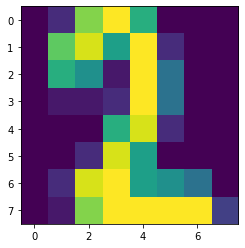

In [33]:
import matplotlib.pyplot as plt

plt.imshow(X_test[2].reshape(8,8))

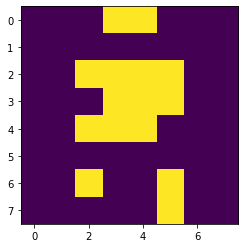

In [32]:
plt.imshow(reconstructed_data[2].reshape(8,8))

In [ ]:
def transform_through_dbn(data, rbms):
    for rbm in rbms:
        data = rbm.transform(data)
    return data
    
# Extract features using DBN
dbn_features = transform_through_dbn(X_train, model)  # Replace with your DBN layers

# Initialize and train the classifier
classifier = LogisticRegression()
classifier.fit(dbn_features, Y_train)

predictions = classifier.predict(transform_through_dbn(X_train, model))

In [29]:
from joblib import dump

dump(model, 'model.joblib')

['model.joblib']